# FRTN50_WEEK_7
## Prerequisites
### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Data specifications

m = 20     # Number of affine functions
n = 2000   # Dimension of the variable x

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
A = np.random.randn(m, n)  # Each row is a_i^T
epsilon = np.random.randn(m) * 1e-2
b = (A[:, 0] + A[:, 1]) / 2 + epsilon  # b_i = (a_i1 + a_i2)/2 + epsilon_i

# Compute L_{f, infinity}
L_f_infty = np.max(np.abs(A))

## The Problem statement
Let us here just repeat the problem statemnt and necessary and the necessary expressions given to us. In this problem, we will study the mirror descent algorithm for solving

$$
\min_{x \in \Delta_n} \max_{i=1,\dots,m} \left| a_i^\top x + b_i \right|
$$

where $(a_i, b_i) \in \mathbb{R}^n \times \mathbb{R}$ for each $i = 1, \dots, m$, and $\Delta_n = \{x \in \mathbb{R}_+^n : 1^\top x = 1\}$ is the unit simplex. Let $f : \mathbb{R}^n \to \mathbb{R}$ such that
$$
f(x) = \max_{i=1,\dots,m} \left| a_i^\top x + b_i \right|
$$
for each $x \in \mathbb{R}^n$. If $x \in \mathbb{R}^n$, then
$$
a_i \operatorname{sgn}(a_i^\top x + b_i) \in \partial f(x)
$$
where $i \in \{1, \dots, m\}$ is any index such that
$$
f(x) = \left| a_i^\top x + b_i \right|.
$$
For future reference, let
$$
L_{f, \infty} = \max_{i \in \{1, \dots, m\}} \| a_i \|_\infty.
$$

## The mirror descent algorithm
Let us also repeat the mirror descent algorithm which we shall implement below. 

<div style="border: 2px solid black; padding: 10px; background-color: #f9f9f9;">

**Mirror Descent Method**

**Initialization:** pick $ x^0 \in \mathbb{R}^n $.

**General step:** for any $ k = 0, 1, 2, \dots, N $, execute the following steps:

1. **(a)** compute $ g^{(k)} \in \partial f(x^{(k)}) $;

2. **(b)** set $ \gamma^{(k)} = \frac{\sqrt{2}}{L_{f, \infty} \sqrt{k+1}} $;

3. **(c)** update $ x^{(k+1)} = \arg\min_{x \in \Delta_n} \left( f(x^{(k)}) + \langle g^{(k)}, x - x^{(k)} \rangle + \frac{1}{\gamma^{(k)}} B_\omega(x, x^{(k)}) \right) $.

**Distance-Generating Function**

The distance-generating function $ \omega: \mathbb{R}^n \to \mathbb{R} \cup \{\infty\} $ is given by

$$
\omega(x) =
\begin{cases}
\sum_{i=1}^n x_i \log x_i, & \text{if } x = (x_1, \dots, x_n) \in \mathbb{R}_+^n, \\
\infty, & \text{otherwise}.
\end{cases}
$$
</div>

Here $B_\omega$ is the Bregman distance.

**Definition 9.2 (Bregman distance).** Let $\omega : \mathbb{E} \to (-\infty, \infty]$ be a proper closed and convex function that is differentiable over $\text{dom}(\partial \omega)$. The *Bregman distance* associated with $\omega$ is the function $B_\omega : \text{dom}(\omega) \times \text{dom}(\partial \omega) \to \mathbb{R}$ given by
$$
B_\omega(\mathbf{x}, \mathbf{y}) = \omega(\mathbf{x}) - \omega(\mathbf{y}) - \langle \nabla \omega(\mathbf{y}), \mathbf{x} - \mathbf{y} \rangle.
$$

Beck shows in example 9.10 the Bregman distance in this case becomes the Kullback-Leibler divergence distance measure:

$$
B_\omega(x, x^{(k)}) = \sum_{i=1}^n x_i \log (x_i/x_i^{(k)}).
$$

Beck also shows in example 9.10 that with this exact set up (negative entropy over the unit simplex), the mirror descent update

$$
 x^{(k+1)} = \arg\min_{x \in \Delta_n} \left( f(x^{(k)}) + \langle g^{(k)}, x - x^{(k)} \rangle + \frac{1}{\gamma^{(k)}} B_\omega(x, x^{(k)}) \right). 
$$

becomes

$$
x_i^{(k+1)} = \frac{x_i^{(k)} e^{-\gamma^{(k)} g_i^{(k)}}}{\sum_{j=1}^{n} x_j^{(k)} e^{-\gamma^{(k)} g_j^{(k)}}}.
$$

This is nice, since we do not have to deal with the implicit $\arg\min$, but we omit the exact derivation for this.

### Convergence of Mirror Descent
In theorem 9.18 Beck shows under certain assumptions, and with the stepsizes

$$
\gamma^{(k)} = \frac{\sqrt{2}}{L_{f, \infty} \sqrt{k+1}},
$$

that we have the following convergence result:

$$
f_{\text{best}}^k - f_{\text{opt}} \leq \frac{L_{f, \infty}}{\sqrt{2\sigma}} \frac{B_\omega(\mathbf{x}^*, \mathbf{x}^0) + 1 + \log(k+1)}{\sqrt{k+1}}.
$$

This suggests a sublinear $\mathcal{O}(\log k/\sqrt{k})$ convergence rate of the best function value suboptimality. In this case $\sigma = 1$ since negative entropy is 1-strongly convex w.r.t. the $l_1$-norm (this is shown in Beck example 5.27).

In [3]:
# Define the mirror descent algorithm as a function
def mirror_descent(A, b, L_f_infty, x_init, N):
    """
    Performs mirror descent algorithm for N iterations.

    Parameters:
    - A: Coefficient matrix (m x n)
    - b: Constant vector (m,)
    - L_f_infty: Maximum infinity norm of gradients
    - x_init: Initial point in the simplex (n,)
    - N: Number of iterations

    Returns:
    - x: Final iterate after N iterations
    - f_xk_list: List of function values f(x^{(k)})
    - f_values: List of function values f(x^{(k)}) - f_opt
    - f_best_values: List of best achieved function values so far
    """
    x = x_init.copy()
    f_values = []
    f_best_values = []
    f_best = np.inf

    # Initialize lists to store function values
    f_xk_list = []

    for k in range(N):
        # Compute subgradient g^{(k)} at x^{(k)}
        residuals = A.dot(x) + b
        abs_residuals = np.abs(residuals)
        i_k = np.argmax(abs_residuals)
        sign = np.sign(residuals[i_k])
        g = A[i_k, :] * sign  # Subgradient

        # Compute stepsize gamma^{(k)}
        gamma = np.sqrt(2) / (L_f_infty * np.sqrt(k + 1))

        # Mirror Descent update
        x = x * np.exp(-gamma * g)
        x /= np.sum(x)  # Project back to simplex

        # Compute f(x^{(k)}) after updating x
        residuals = A.dot(x) + b
        abs_residuals = np.abs(residuals)
        f_xk = np.max(abs_residuals)
        f_xk_list.append(f_xk)

        # Update best function value
        if f_xk < f_best:
            f_best = f_xk

        # Store function values (we will compute f_opt later)
        f_values.append(f_xk)  # Placeholder for now
        f_best_values.append(f_best)  # Placeholder for now

    return x, f_xk_list, f_values, f_best_values

# Initial point x^{(0)}
x_init = np.full(n, 1 / n)

# Run the mirror descent algorithm for a large number of iterations to estimate f_opt and x^*
N_large = 10**5  # Number of iterations to estimate f_opt
x_star, f_xk_list_large, _, _ = mirror_descent(A, b, L_f_infty, x_init, N_large)

# Estimate f_opt as the minimum value obtained
f_opt = np.min(f_xk_list_large)

print(f"Estimated f_opt after {N_large} iterations: {f_opt}")

# Compute B_\omega( x^*, x^{(0)} )
Bregman_distance = np.sum(x_star * np.log(n * x_star))

# Now run the algorithm for a smaller number of iterations using the estimated f_opt
N = 10**4  # Number of iterations for plotting
_, f_xk_list, f_values, f_best_values = mirror_descent(A, b, L_f_infty, x_init, N)

# Subtract f_opt to compute suboptimality
f_values = np.array(f_xk_list) - f_opt
f_best_values = np.minimum.accumulate(f_values)  # Best achieved suboptimality so far

iterations = np.arange(N)  # Iteration indices

# Compute theoretical upper bound for each iteration
sigma = 1  # Strong convexity parameter
B = Bregman_distance
upper_bound = (L_f_infty / np.sqrt(2 * sigma)) * (B + 1 + np.log(iterations + 1)) / np.sqrt(iterations + 1)

Estimated f_opt after 100000 iterations: 0.06501491304480134


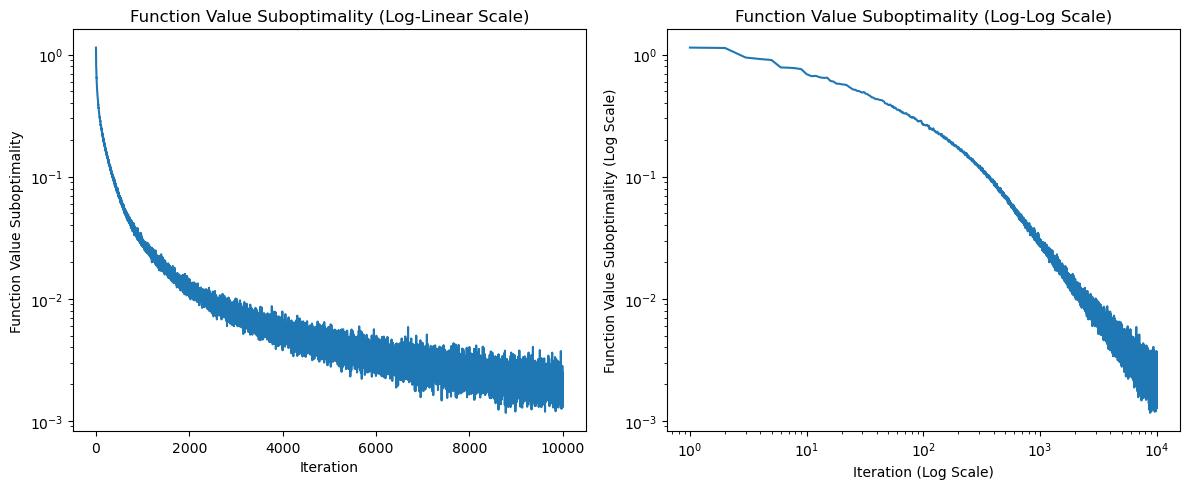

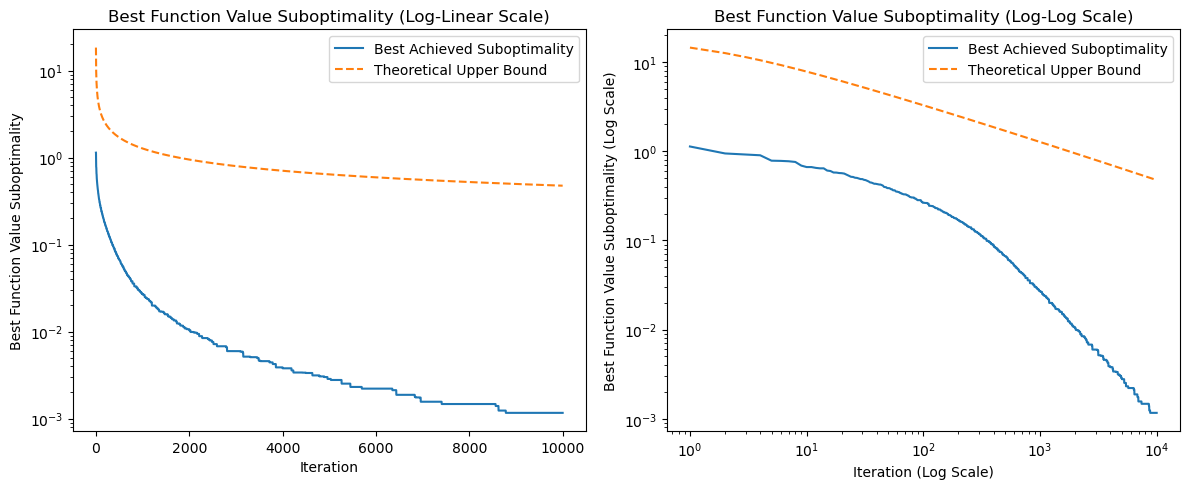

In [4]:
# Plot settings
plt.figure(figsize=(12, 5))

# Function value suboptimality: log-linear scale
plt.subplot(1, 2, 1)
plt.plot(iterations, f_values)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Function Value Suboptimality')
plt.title('Function Value Suboptimality (Log-Linear Scale)')

# Function value suboptimality: log-log scale
plt.subplot(1, 2, 2)
plt.plot(iterations + 1, f_values)  # iterations + 1 to avoid log(0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration (Log Scale)')
plt.ylabel('Function Value Suboptimality (Log Scale)')
plt.title('Function Value Suboptimality (Log-Log Scale)')
plt.tight_layout()
plt.show()


# Plot settings
plt.figure(figsize=(12, 5))

# Best achieved function value suboptimality: log-linear scale
plt.subplot(1, 2, 1)
plt.plot(iterations, f_best_values, label='Best Achieved Suboptimality')
plt.plot(iterations, upper_bound, label='Theoretical Upper Bound', linestyle='--')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value Suboptimality')
plt.title('Best Function Value Suboptimality (Log-Linear Scale)')
plt.legend()

# Best achieved function value suboptimality: log-log scale
plt.subplot(1, 2, 2)
plt.plot(iterations[1:], f_best_values[1:], label='Best Achieved Suboptimality')
plt.plot(iterations[1:], upper_bound[1:], label='Theoretical Upper Bound', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration (Log Scale)')
plt.ylabel('Best Function Value Suboptimality (Log Scale)')
plt.title('Best Function Value Suboptimality (Log-Log Scale)')
plt.legend()

plt.tight_layout()
plt.show()


## Discussion

From the results, we observe that the function value suboptimality decreases and approaches zero as the number of iterations increases. After 10,000 steps, the suboptimality reaches approximately $10^{-3}$, which may or may not be sufficient for practical purposes, depending on the context.

Our implementation satisfies the theoretical upper bound provided by Theorem 9.18, confirming both the correctness of the algorithm and the validity of the theoretical analysis. The convergence rate aligns with the worst-case scenario of $\mathcal{O}(\log k / \sqrt{k})$ for the best achieved suboptimality.

In the log-linear plot, the suboptimality seems to follow a similar trend to the theoretical upper bound, suggesting that over long periods, the convergence rate matches the expected rate. However, the log-log plot indicates that the convergence might be slightly faster than $\mathcal{O}(\log k / \sqrt{k})$, which is acceptable since the theoretical rate is a worst-case estimate.

In summary, the mirror descent algorithm effectively reduces the function value suboptimality over iterations, and the empirical results are consistent with theoretical predictions.